In [5]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
from helper import Helper

class Calibrator:
    def __init__(self, x_corners, y_corners):        

        self.nx = x_corners
        self.ny = y_corners        
        
        #Has to be computed in compute_img_pts()
        self.objpoints = []
        self.imgpoints = []        
        
        #Calibration params. should be computed in calibrate_camera()
        self.calib_params = {}
    def compute_img_pts(self, calib_images_path, show_corners=True):
        
        objp = np.zeros((self.ny * self.nx, 3), np.float32)
        objp[:,:2] = np.mgrid[0:self.nx, 0:self.ny].T.reshape(-1, 2)
            
        # Make a list of calibration images
        images = glob.glob(calib_images_path)

        # Step through the list and search for chessboard corners
        for idx, fname in enumerate(images):
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (self.nx, self.ny), None)

            
            # If found, add object points, image points
            if ret == True:
                self.objpoints.append(objp)
                self.imgpoints.append(corners)

                # Draw and display the corners
                cv2.drawChessboardCorners(img, (self.nx, self.ny), corners, ret)        
                
                if show_corners:
                    plt.imshow(img)
                    plt.show()
        
        print ('corners found. please check self.imgpoints')
    
    def calibrate_camera(self, image_path):
        if len(self.imgpoints) == 0 or len(self.objpoints) == 0:
            raise Exception("calibration unsuccessful. Have you executed compute_img_pts() ?")
        
        img = cv2.imread(image_path)
        img_size = (img.shape[1], img.shape[0])
        
        self.calib_params['ret'], \
        self.calib_params['mtx'], \
        self.calib_params['dist'], \
        self.calib_params['rvecs'], \
        self.calib_params['tvecs'] = cv2.calibrateCamera(self.objpoints, self.imgpoints, img_size, None, None)
        
        return self.calib_params
        
        
    def store_calib_coeffs(self, store_path):
        if len(self.calib_params) == 0:
            raise Exception('calib_params is empty. Have you run calibrate_camera ??')
            
        pickle.dump( self.calib_params, open( store_path, "wb" ) )
        print ('stored calib coeffs @ ' + store_path)
        
    
    def undistort_image(self, img):
        dst = cv2.undistort(img, self.calib_params['mtx'], self.calib_params['dist'], None, self.calib_params['mtx'])
        return dst


corners found. please check self.imgpoints
stored calib coeffs @ ../data/calib_coeffs.pickle


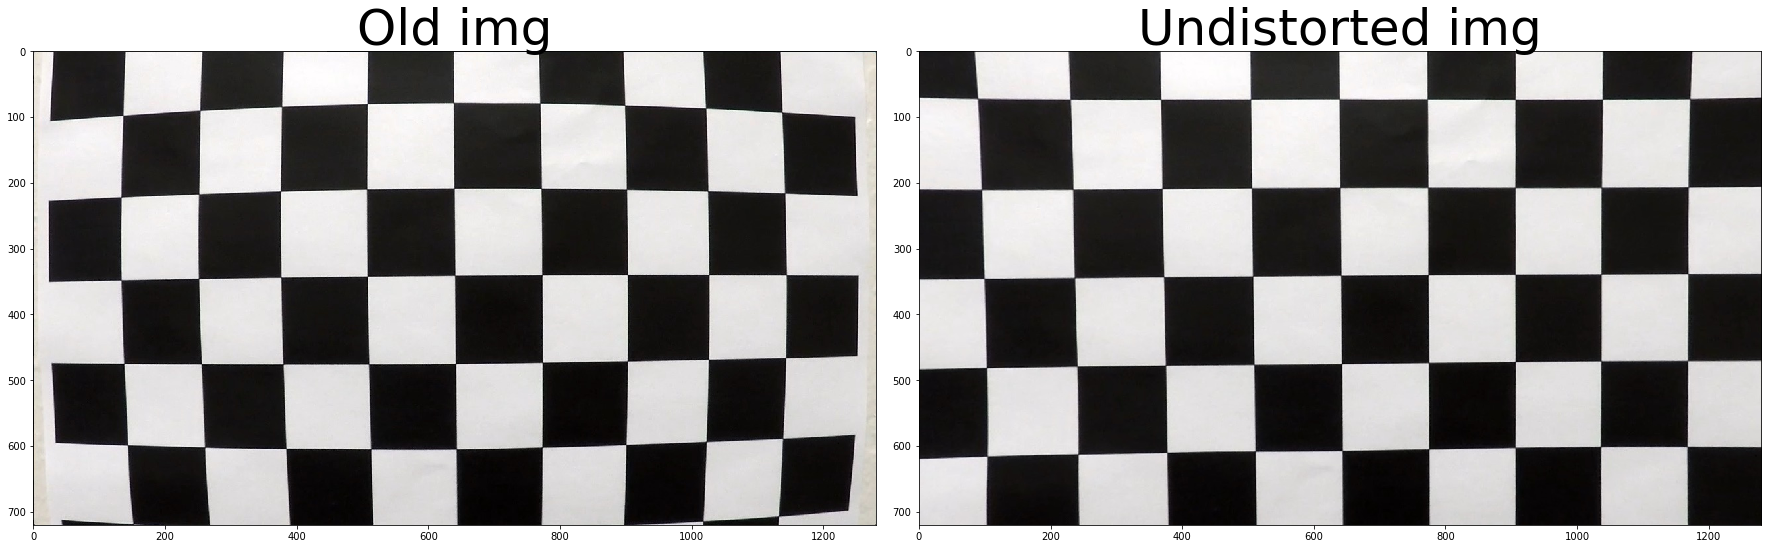

In [6]:
h = Helper()

cal = Calibrator(x_corners=9, y_corners=6)

calib_images_path = '../camera_cal/*.jpg'
cal.compute_img_pts(calib_images_path, False)

test_image_path = '../camera_cal/calibration1.jpg'
cal.calibrate_camera(test_image_path)

cal.store_calib_coeffs('../data/calib_coeffs.pickle')

img = h.load_image(test_image_path)
und_img = cal.undistort_image(img)
h.parallel_plots(img, 'Old img', und_img, 'Undistorted img')

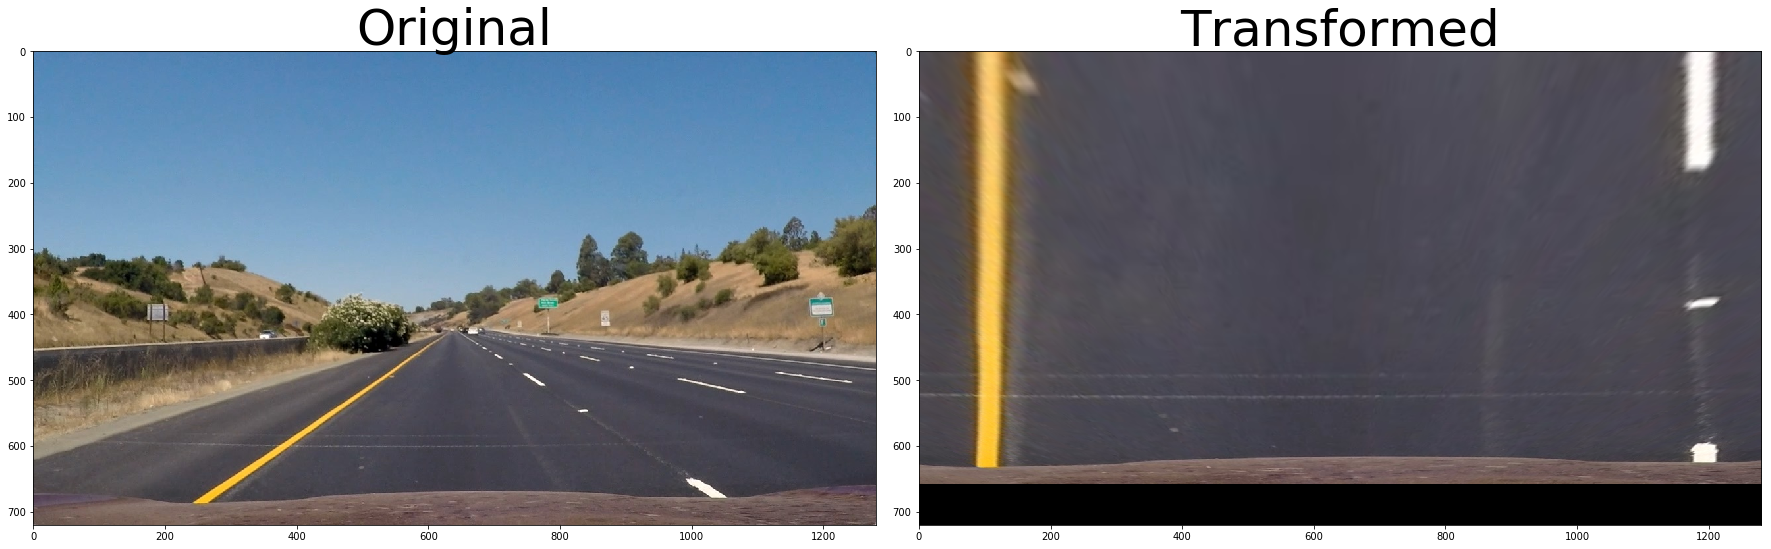

In [84]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
from helper import Helper


class Transformer:
    def __init__(self):
        pass
    
    def transform(self, img, corners, offset):

        x = img.shape[1]
        y = img.shape[0]
        
        src = np.float32(corners)

        img_size = (x, y)    

        dst = np.float32([(0 + offset, 0 + offset), \
                          (x - offset, 0 + offset), \
                          (x - offset, y - offset), \
                          (0 + offset, y - offset)])

        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
        return warped, M

h = Helper()

img = h.load_image('../test_images/straight_lines1.jpg')  
t = Transformer()
corners = [(525, 499), (760, 499), (1026, 673), (270, 673)]
top_down, perspective_M = t.transform(img,corners , offset=100)
h.parallel_plots(img, 'Original', top_down, 'Transformed')


In [51]:
class Thresholder:
    def __init__(self):
        pass

    def absolute_threshold(self, img, orient='x', thresh_min=0, thresh_max=255, sobel_kernel=3):

            
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Apply x or y gradient with the OpenCV Sobel() function
        # and take the absolute value
        if orient == 'x':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
        if orient == 'y':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        # Rescale back to 8 bit integer
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        # Create a copy and apply the threshold
        binary_output = np.zeros_like(scaled_sobel)
        # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
        binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
        # Return the result
        return binary_output
    
    def magnitude_threshold(self, img, sobel_kernel=3, mag_thresh=(0, 255)):
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Take both Sobel x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Calculate the gradient magnitude
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        # Rescale to 8 bit
        scale_factor = np.max(gradmag)/255 
        gradmag = (gradmag/scale_factor).astype(np.uint8) 
        # Create a binary image of ones where threshold is met, zeros otherwise
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

        # Return the binary image
        return binary_output
    
    def direction_threshold(self, img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
        # Apply the following steps to img
        # 1) Convert to grayscale
        # 2) Take the gradient in x and y separately
        # 3) Take the absolute value of the x and y gradients
        # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
        # 5) Create a binary mask where direction thresholds are met
        # 6) Return this mask as your binary_output image
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
        abs_sobelx  = np.sqrt(np.square(sobelx)) 
        abs_sobely  = np.sqrt(np.square(sobely))
        direction = np.arctan2(abs_sobely, abs_sobelx)
        sbinary = np.zeros_like(direction)
        sbinary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
        return sbinary

    def hls_threshold(self, img, thresh=(0, 255)):
        # 1) Convert to HLS color space
        # 2) Apply a threshold to the S channel
        # 3) Return a binary image of threshold result
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        S = hls[:,:,2]
        binary_output = np.zeros_like(S)
        binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
        
        return binary_output
    
    
    
    

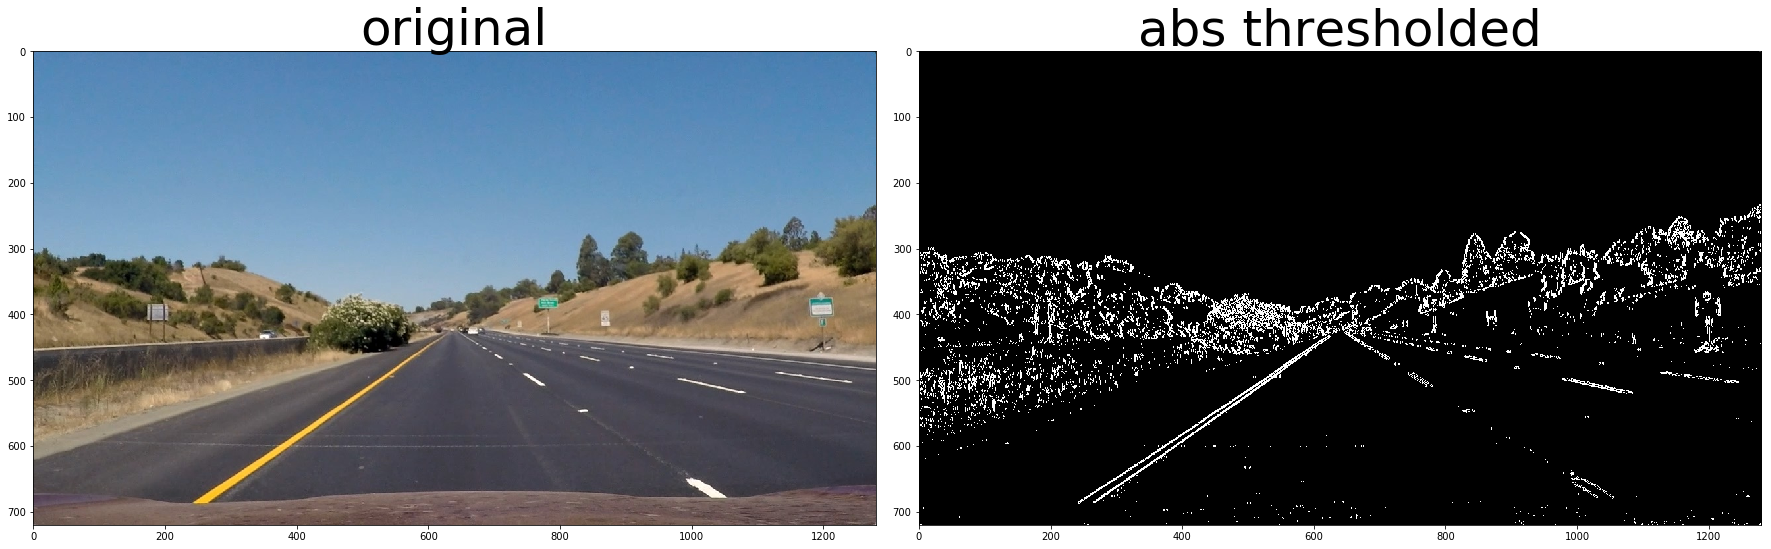

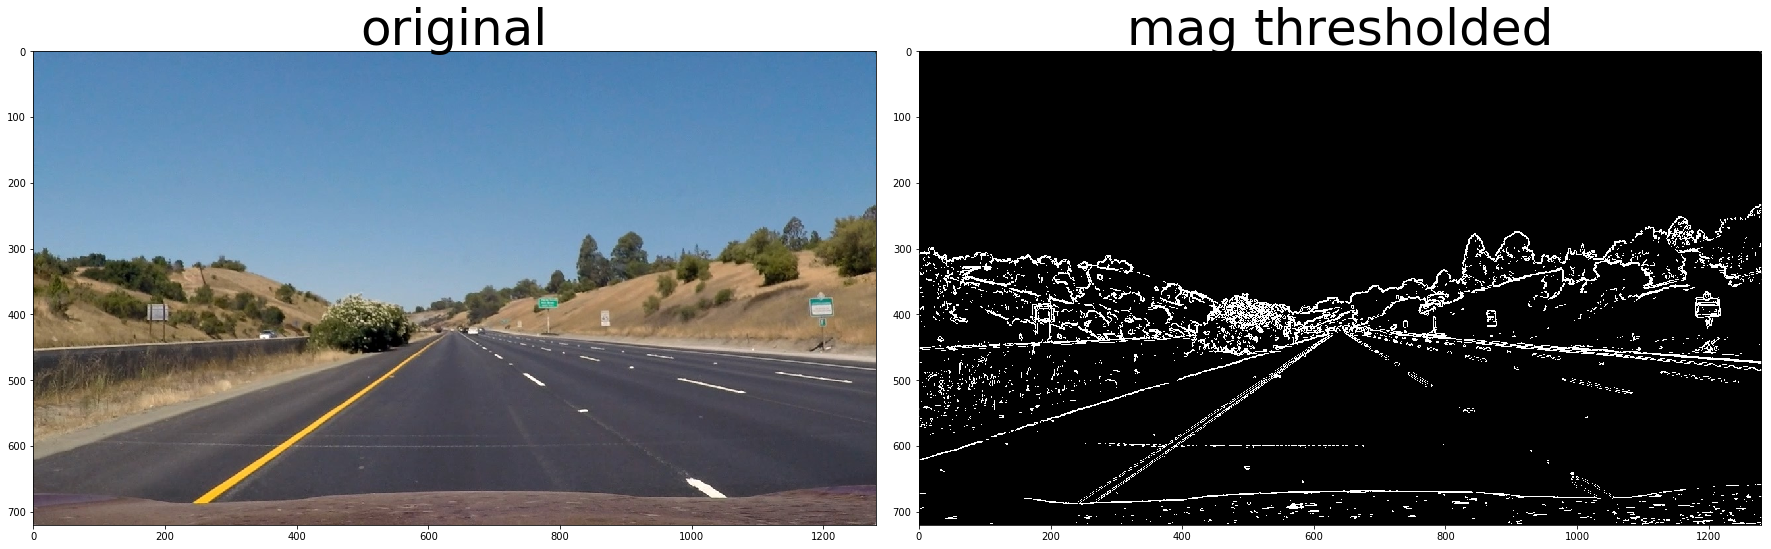

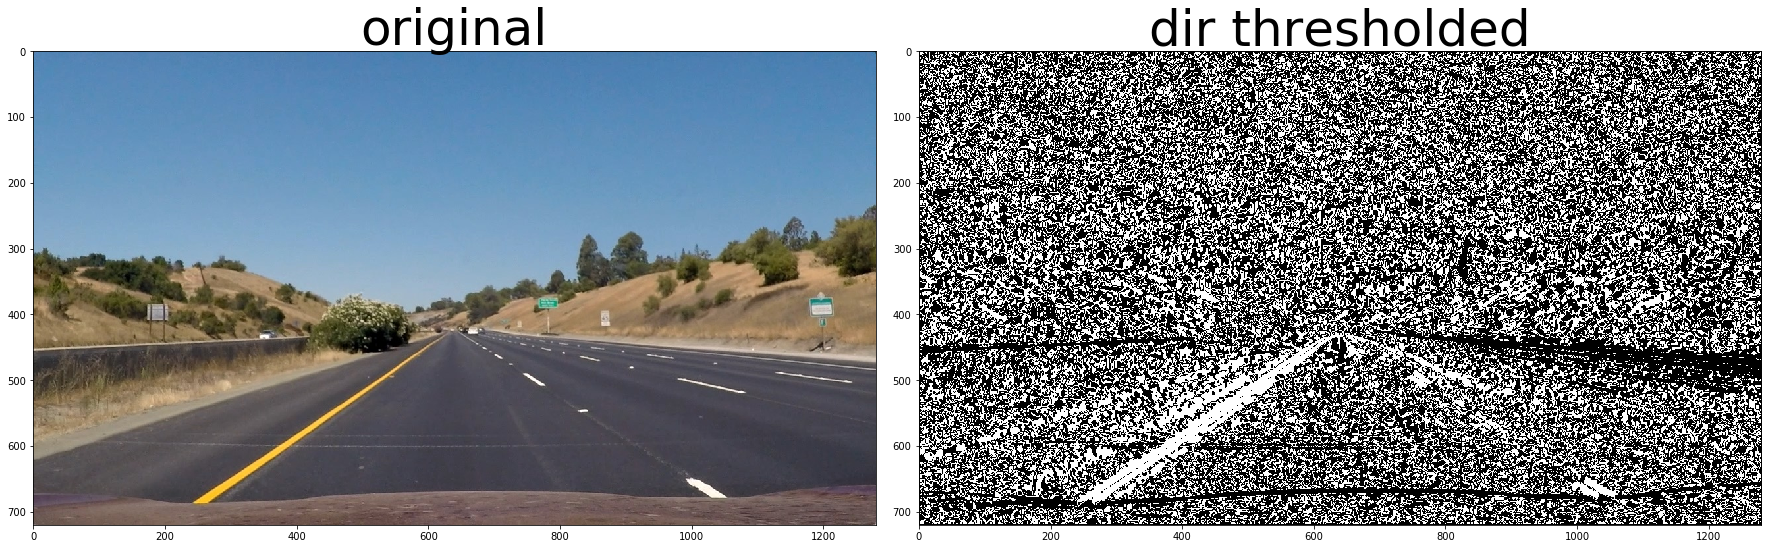

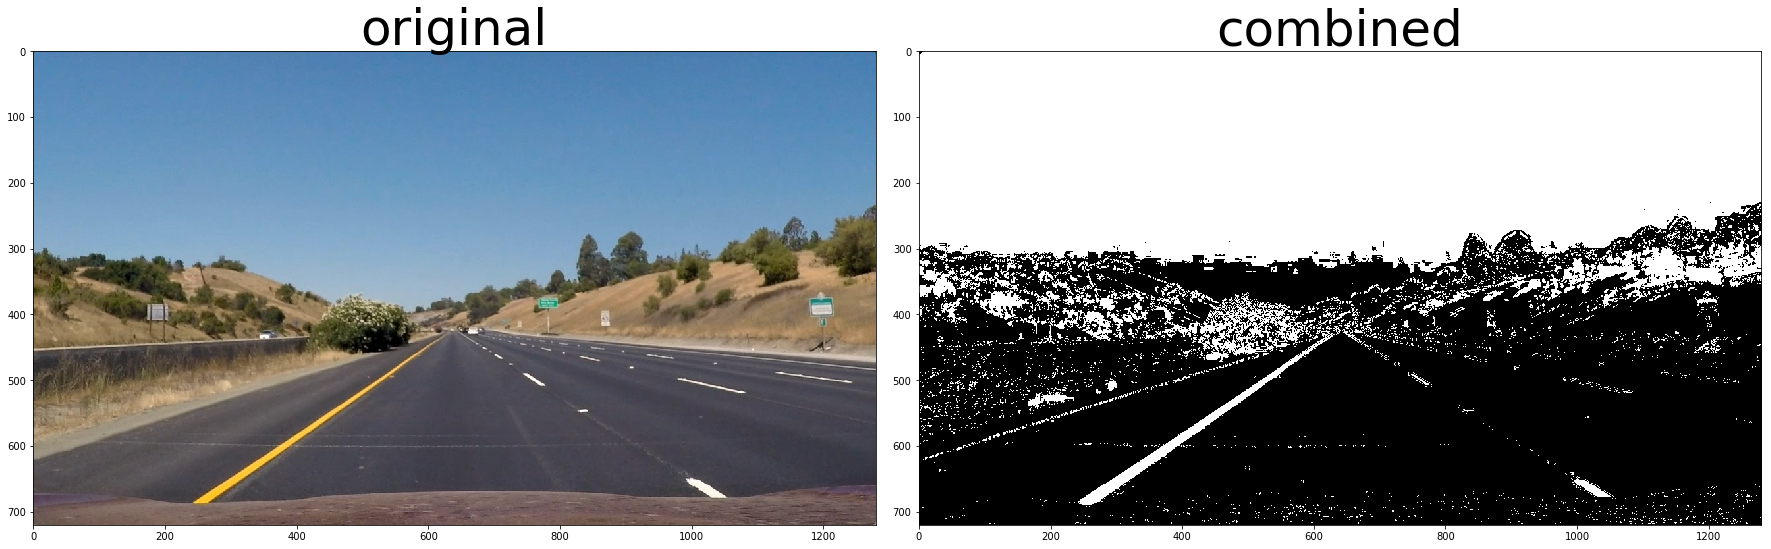

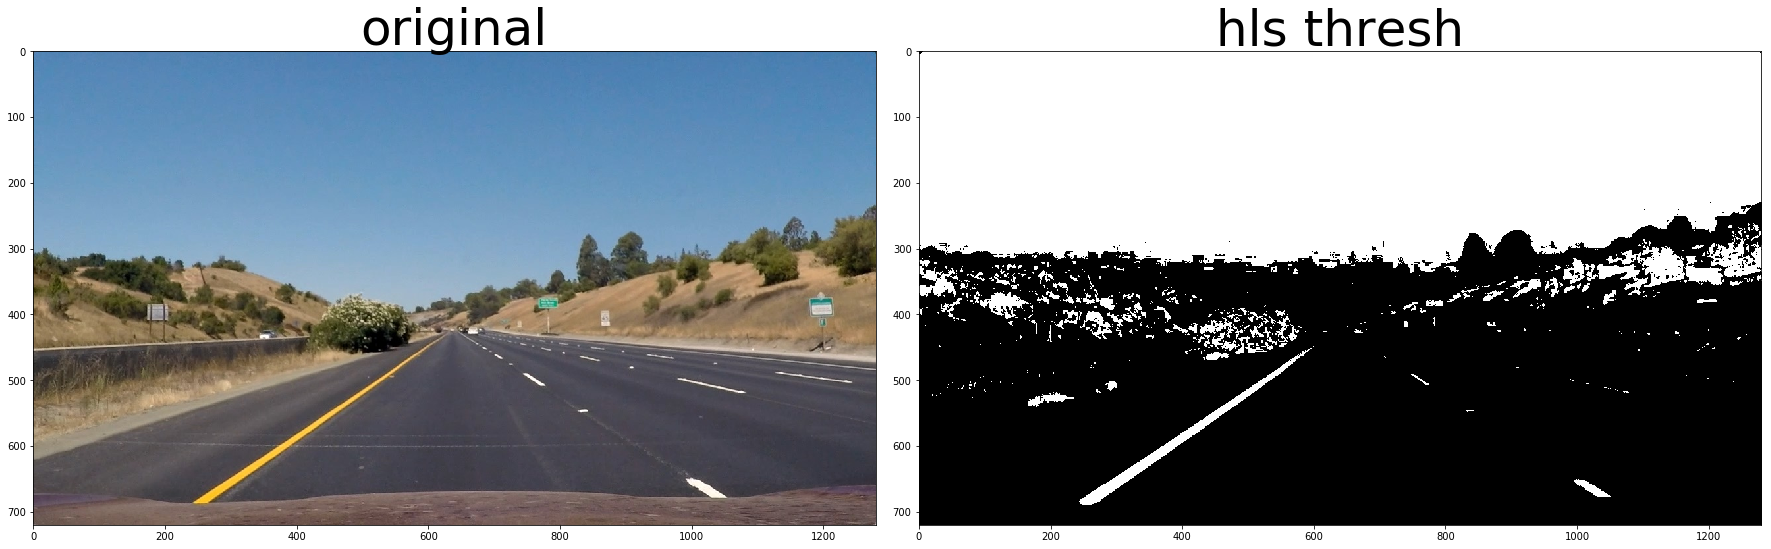

In [73]:
img = h.load_image('../test_images/straight_lines1.jpg')  
t = Thresholder()

op = t.absolute_threshold(img, orient='x', thresh_min=20, thresh_max=100, sobel_kernel=3)
# Plot the result
h.parallel_plots(img,'original', op, 'abs thresholded', None, 'gray')


op = t.magnitude_threshold(img, sobel_kernel=3, mag_thresh=(30, 100))
# Plot the result
h.parallel_plots(img,'original', op, 'mag thresholded', None, 'gray')

op = t.direction_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
h.parallel_plots(img,'original', op, 'dir thresholded', None, 'gray')


ksize=3
s_thres = t.hls_threshold(img, thresh=(90, 255))
gradx = t.absolute_threshold(img, orient='x', thresh_min=20, thresh_max=100, sobel_kernel=ksize)
grady = t.absolute_threshold(img, orient='y', thresh_min=20, thresh_max=100, sobel_kernel=ksize)
mag_binary = t.magnitude_threshold(img, sobel_kernel=ksize, mag_thresh=(20, 100))
dir_binary = t.direction_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))

op = np.zeros_like(dir_binary)
op[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (s_thres == 1)] = 1
h.parallel_plots(img,'original', op, 'combined', None, 'gray')


op = t.hls_threshold(img, thresh=(90, 255))
h.parallel_plots(img,'original', op, 'hls thresh', None, 'gray')


In [109]:
class LaneFinder:
    def __init__(self):
        pass
    
    def hist(self, img):
        # TO-DO: Grab only the bottom half of the image
        # Lane lines are likely to be mostly vertical nearest to the car
        bottom_half = img[img.shape[0]//2:,:]

        # TO-DO: Sum across image pixels vertically - make sure to set `axis`
        # i.e. the highest areas of vertical lines should be larger values
        histogram = np.sum(bottom_half, axis=0)

        return histogram
    
    def find_lane_pixels(self, binary_warped):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = 9
        # Set the width of the windows +/- margin
        margin = 200
        # Set minimum number of pixels found to recenter window
        minpix = 50

        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        leftx = []
        lefty = []
        rightx = []
        righty = []    

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            ### TO-DO: Find the four below boundaries of the window ###
            win_xleft_low = leftx_current - int((margin/2))
            win_xleft_high = leftx_current + int((margin/2))
            win_xright_low = rightx_current - int((margin/2))
            win_xright_high = rightx_current + int((margin/2))

            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 

            ### TO-DO: Identify the nonzero pixels in x and y within the window ###
            good_left_inds = []
            good_right_inds = []


            for x, y in zip(nonzerox, nonzeroy):
                if x >= win_xleft_low and x < win_xleft_high and y >= win_y_low and y < win_y_high:
                    good_left_inds.append((x, y))
                    leftx.append(x)
                    lefty.append(y)

                if x >= win_xright_low and x < win_xright_high and y >= win_y_low and y < win_y_high:
                    good_right_inds.append((x, y))
                    rightx.append(x)
                    righty.append(y)


            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)


            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean([x for x, y in good_left_inds]))
            if len(good_right_inds) > minpix:
                rightx_current = np.int(np.mean([x for x, y in good_right_inds]))


        return leftx, lefty, rightx, righty, out_img    
    
    def fit_polynomial(self, binary_warped):
        # Find our lane pixels first
        leftx, lefty, rightx, righty, out_img = self.find_lane_pixels(binary_warped)

        ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        try:
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty

        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')

        return out_img, {'left_fit' : left_fit, 'right_fit' : right_fit}
    
    def search_around_poly(self, binary_warped, left_fit, right_fit):
        # HYPERPARAMETER
        # Choose the width of the margin around the previous polynomial to search
        # The quiz grader expects 100 here, but feel free to tune on your own!
        margin = 100

        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        ### TO-DO: Set the area of search based on activated x-values ###
        ### within the +/- margin of our polynomial function ###
        ### Hint: consider the window areas for the similarly named variables ###
        ### in the previous quiz, but change the windows to our new search area ###

        left_poly_x = left_fit[0]*nonzeroy**2 + \
                        left_fit[1]*nonzeroy**1 + \
                        left_fit[2]

        right_poly_x =  right_fit[0]*nonzeroy**2 + \
                        right_fit[1]*nonzeroy**1 + \
                        right_fit[2]

        left_lane_inds = []
        right_lane_inds = []

        for i, x in enumerate(nonzerox):        
            if x <= left_poly_x[i] + margin and x >= left_poly_x[i] - margin:
                left_lane_inds.append(i)

            if x <= right_poly_x[i] + margin and x >= right_poly_x[i] - margin:
                right_lane_inds.append(i)        

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # Fit new polynomials
        left_fitx, right_fitx, ploty = self.fit_poly_2(binary_warped.shape, leftx, lefty, rightx, righty)

        ## Visualization ##
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Plot the polynomial lines onto the image
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        ## End visualization steps ##

        return result    
    
    def fit_poly_2(self, img_shape, leftx, lefty, rightx, righty):
        ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
        ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    

        return left_fitx, right_fitx, ploty
    

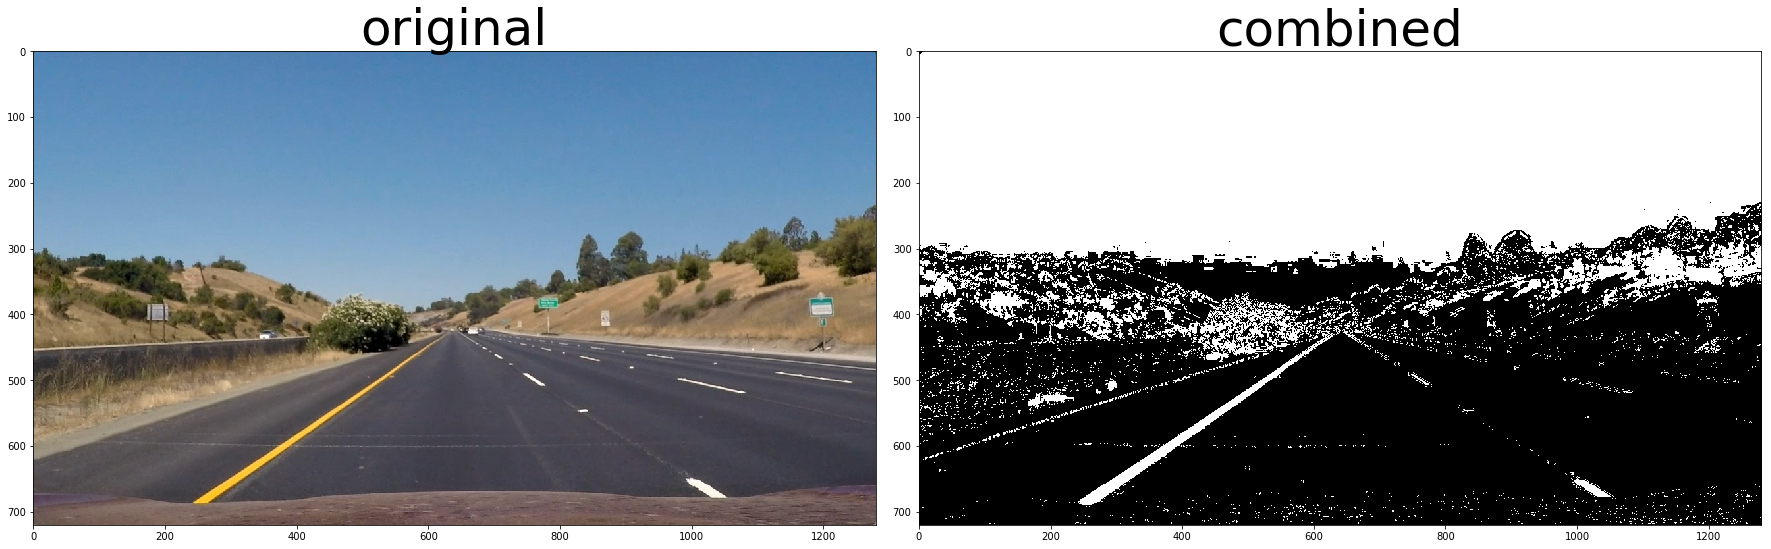

In [97]:
ksize=3
t = Thresholder()
s_thres = t.hls_threshold(img, thresh=(90, 255))
gradx = t.absolute_threshold(img, orient='x', thresh_min=20, thresh_max=100, sobel_kernel=ksize)
grady = t.absolute_threshold(img, orient='y', thresh_min=20, thresh_max=100, sobel_kernel=ksize)
mag_binary = t.magnitude_threshold(img, sobel_kernel=ksize, mag_thresh=(20, 100))
dir_binary = t.direction_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))

op = np.zeros_like(dir_binary)
op[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (s_thres == 1)] = 1
h.parallel_plots(img,'original', op, 'combined', None, 'gray')


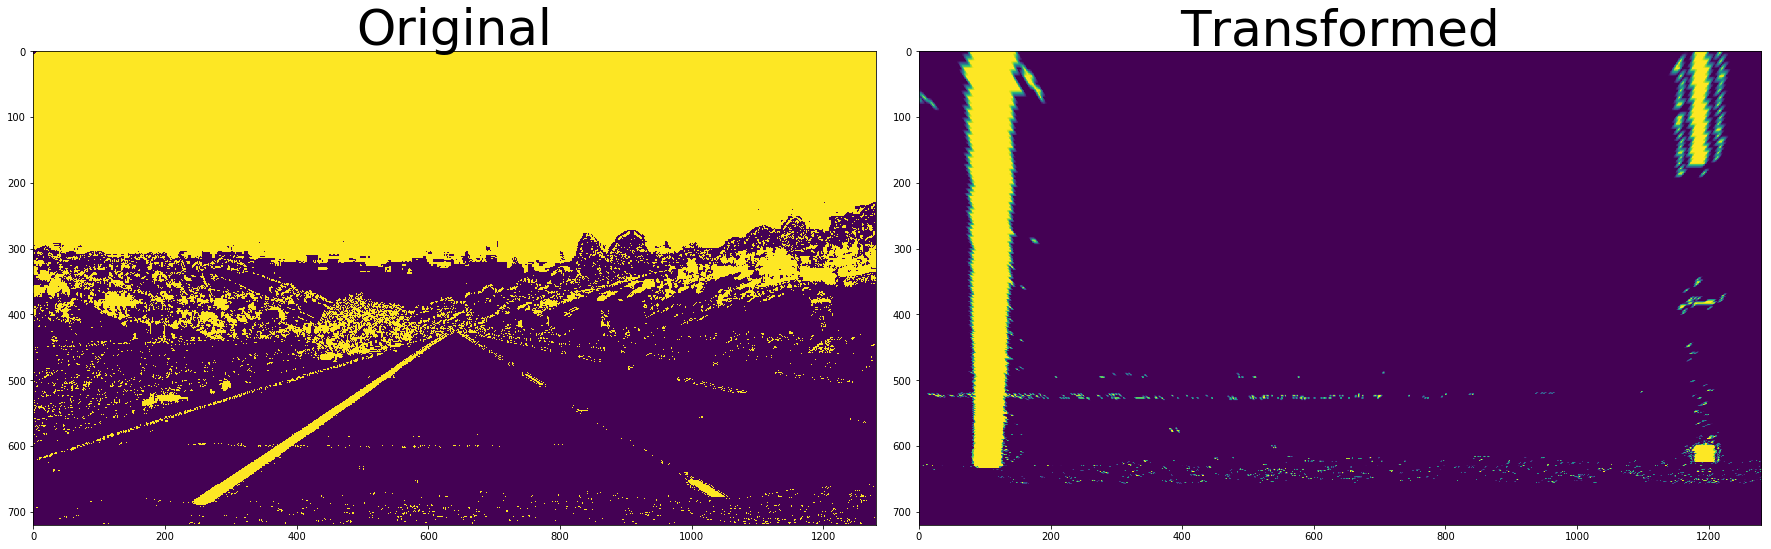

In [98]:
t = Transformer()
corners = [(525, 499), (760, 499), (1026, 673), (270, 673)]
top_down, perspective_M = t.transform(op,corners , offset=100)
h.parallel_plots(op, 'Original', top_down, 'Transformed')

(1280,)

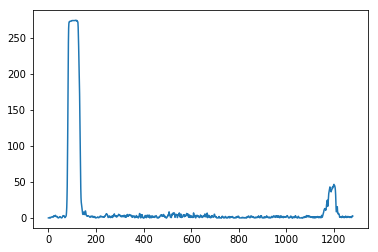

In [111]:
l = LaneFinder()
histogram = l.hist(top_down)
plt.plot(histogram)
histogram.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


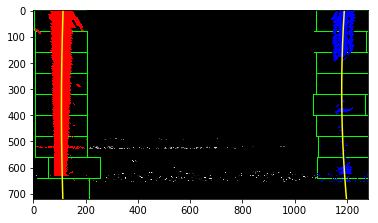

In [112]:
img, fits = l.fit_polynomial(top_down)
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


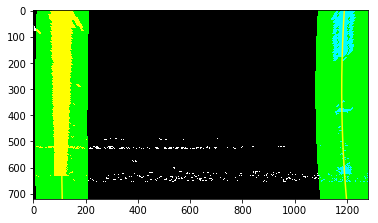

In [115]:
plt.imshow(l.search_around_poly(top_down, fits['left_fit'], fits['right_fit']))